In [17]:
from tensorflow.keras.layers import Dense,Flatten,Lambda,Input
from tensorflow.keras.models import Model

In [22]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [5]:
from tensorflow.keras.preprocessing import image

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

In [8]:
IMAGE_SIZE = [100, 100] 
epochs = 5
batch_size = 32

In [9]:
!unzip dataset.zip

Archive:  dataset.zip
   creating: dataset/training/
   creating: dataset/training/cats/
  inflating: dataset/training/cats/cat.100.jpg  
  inflating: dataset/training/cats/cat.101.jpg  
  inflating: dataset/training/cats/cat.102.jpg  
  inflating: dataset/training/cats/cat.103.jpg  
  inflating: dataset/training/cats/cat.104.jpg  
  inflating: dataset/training/cats/cat.105.jpg  
  inflating: dataset/training/cats/cat.106.jpg  
  inflating: dataset/training/cats/cat.107.jpg  
  inflating: dataset/training/cats/cat.108.jpg  
  inflating: dataset/training/cats/cat.109.jpg  
  inflating: dataset/training/cats/cat.110.jpg  
  inflating: dataset/training/cats/cat.111.jpg  
  inflating: dataset/training/cats/cat.112.jpg  
  inflating: dataset/training/cats/cat.113.jpg  
  inflating: dataset/training/cats/cat.114.jpg  
  inflating: dataset/training/cats/cat.115.jpg  
  inflating: dataset/training/cats/cat.116.jpg  
  inflating: dataset/training/cats/cat.117.jpg  
  inflating: dataset/training

In [10]:
train_path = 'dataset/training'
valid_path = 'dataset/validation'

# useful for getting number of files
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')


In [11]:
folders = glob(train_path + '/*')


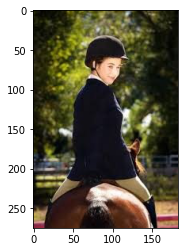

In [13]:
plt.imshow(image.img_to_array(image.load_img(np.random.choice(image_files))).astype('uint8'))
plt.show()

In [14]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
for layer in vgg.layers:
  layer.trainable = False


58889256/58889256 [==============================] - 1s 0us/step


In [15]:
x = Flatten()(vgg.output)
x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [18]:
model=Model(inputs=vgg.input, outputs=prediction)

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [20]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)


In [23]:
gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)

In [24]:
test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)



Found 196 images belonging to 4 classes.
{'cats': 0, 'dogs': 1, 'horses': 2, 'humans': 3}


In [25]:
labels = [None] * len(test_gen.class_indices)


In [26]:
labels

[None, None, None, None]

In [27]:
for k, v in test_gen.class_indices.items():
  labels[v] = k

In [28]:
labels

['cats', 'dogs', 'horses', 'humans']

min: -123.56997 max: 149.87411
[0. 0. 0. 1.]


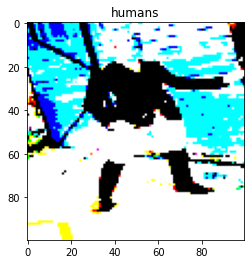

In [31]:
for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  print(y[0])
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

In [32]:
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

Found 612 images belonging to 4 classes.


In [33]:
valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

Found 196 images belonging to 4 classes.


In [34]:
r = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)

Epoch 1/5
19/19 [==============================] - 85s 4s/step - loss: 29.7455 - accuracy: 0.6362 - val_loss: 5.8770 - val_accuracy: 0.7708
Epoch 2/5
19/19 [==============================] - 82s 4s/step - loss: 3.8196 - accuracy: 0.8224 - val_loss: 2.2632 - val_accuracy: 0.8542
Epoch 3/5
19/19 [==============================] - 81s 4s/step - loss: 1.9020 - accuracy: 0.8603 - val_loss: 1.2341 - val_accuracy: 0.9010
Epoch 4/5
19/19 [==============================] - 81s 4s/step - loss: 1.6904 - accuracy: 0.8793 - val_loss: 5.4427 - val_accuracy: 0.7396
Epoch 5/5
19/19 [==============================] - 82s 4s/step - loss: 1.6680 - accuracy: 0.8759 - val_loss: 1.5327 - val_accuracy: 0.8854


In [35]:
def get_confusion_matrix(data_path, N):
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm

In [36]:
cm = get_confusion_matrix(train_path, len(image_files))
print(cm)
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)

Generating confusion matrix 612
Found 612 images belonging to 4 classes.
2/2 [==============================] - 4s 429ms/step
[[143   8   0   2]
 [ 22 152   3   4]
 [  2   9 140   2]
 [  3   1   3 118]]
Generating confusion matrix 196
Found 196 images belonging to 4 classes.
1/1 [==============================] - 0s 431ms/step
[[44  2  1  2]
 [ 6 13  1  1]
 [ 4  0 45  0]
 [ 3  1  1 72]]


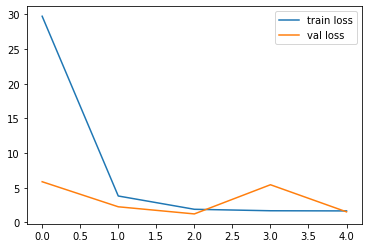

In [37]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()


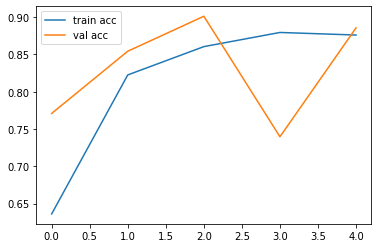

In [38]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
